<a href="https://colab.research.google.com/github/NitheeshKumar-k/Pix2Pix-Implementation/blob/main/Pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'Tesla T4')

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets and save in google drive and reuse it from drive

In [4]:
def download_pix2pix_dataset(dataset_name: str, extract: bool = True, save_to_drive: bool = True):
    # Define paths
    drive_path = f"/content/drive/MyDrive/pix2pix_datasets/{dataset_name}"
    local_tar = f"/content/{dataset_name}.tar.gz"
    local_path = f"/content/{dataset_name}"
    base_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/"
    dataset_url = f"{base_url}{dataset_name}.tar.gz"

    # 1 Check if dataset exists in Google Drive
    if os.path.exists(drive_path):
        print(f"Dataset '{dataset_name}' found in Google Drive. Loading from there...")
        os.system(f"cp -r '{drive_path}' /content/")
        return local_path

    # 2 If not found, check if already exists in Colab
    if os.path.exists(local_path):
        print(f"Dataset '{dataset_name}' already exists in Colab at {local_path}")
        return local_path

    # 3️ Otherwise, download the dataset
    print(f"Downloading {dataset_name} dataset from Berkeley repository...")
    os.system(f"wget -q {dataset_url} -O {local_tar}")

    # 4️ Extract the dataset
    if extract:
        print(f"Extracting {dataset_name}.tar.gz ...")
        os.system(f"tar -xzf {local_tar}")
        print(f"Dataset '{dataset_name}' extracted to {local_path}")
    else:
        print(f"Downloaded {dataset_name}.tar.gz (extraction skipped)")

    # 5️ Optionally save a copy to Google Drive
    if save_to_drive:
        print(f"Saving dataset '{dataset_name}' to Google Drive...")
        os.makedirs(os.path.dirname(drive_path), exist_ok=True)
        os.system(f"cp -r {local_path} '{drive_path}'")
        print(f"Saved to: {drive_path}")

    # 6️ Cleanup the tar file
    if os.path.exists(local_tar):
        os.remove(local_tar)

    return local_path

In [5]:
# Facades dataset
dataset_path = download_pix2pix_dataset("facades")
dataset_path

Dataset 'facades' found in Google Drive. Loading from there...


'/content/facades'

## Data Preprocessing and Augmentation

In [6]:
def get_pix2pix_transforms(image_size=256):
    return transforms.Compose([
        transforms.Resize((286, 286)),
        transforms.RandomCrop((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # scale to [-1, 1]
    ])

##Custom Class to Pair images for training

In [7]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, mode='train', image_size=256):
        self.dir = os.path.join(root_dir, mode)
        self.image_files = os.listdir(self.dir)
        self.image_size = image_size

        # Basic transforms (no crop/flip yet)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Split the image in half before any augmentations
        w, h = image.size
        input_img = image.crop((0, 0, w//2, h))
        target_img = image.crop((w//2, 0, w, h))

        # Resize both
        resize = transforms.Resize((286, 286))
        input_img = resize(input_img)
        target_img = resize(target_img)

        # Random crop (same area for both)
        i, j, h, w = transforms.RandomCrop.get_params(input_img, output_size=(self.image_size, self.image_size))
        input_img = transforms.functional.crop(input_img, i, j, h, w)
        target_img = transforms.functional.crop(target_img, i, j, h, w)

        # Random horizontal flip (apply same decision to both)
        if random.random() > 0.5:
            input_img = transforms.functional.hflip(input_img)
            target_img = transforms.functional.hflip(target_img)

        # To tensor and normalize
        input_img = self.normalize(self.to_tensor(input_img))
        target_img = self.normalize(self.to_tensor(target_img))

        return input_img, target_img

In [8]:
train_dataset = Pix2PixDataset(dataset_path, mode='train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


## Visulaizing Images

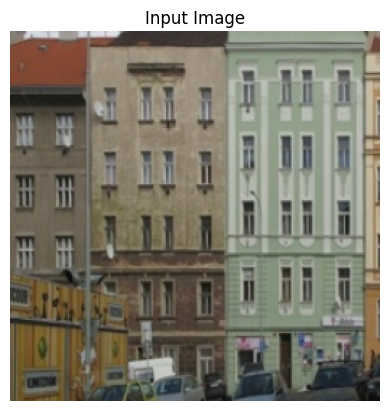

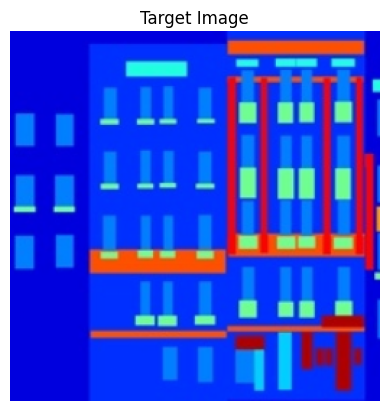

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_tensor_image(tensor_img):
    img = tensor_img.detach().cpu().numpy()
    img = (img * 0.5) + 0.5  # denormalize from [-1, 1] to [0, 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

inputs, targets = next(iter(train_loader))
show_tensor_image(inputs[0])
plt.title("Input Image")
plt.show()

show_tensor_image(targets[0])
plt.title("Target Image")
plt.show()


### Implementation U-Net Generator

In [10]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Concatenate skip connection
        x = torch.cat((x, skip_input), 1)
        return x

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()

        # Encoder (Downsampling path)
        self.down1 = UNetDown(in_channels, 64, normalize=False)   # 256 → 128
        self.down2 = UNetDown(64, 128)                            # 128 → 64
        self.down3 = UNetDown(128, 256)                           # 64 → 32
        self.down4 = UNetDown(256, 512, dropout=0.5)              # 32 → 16
        self.down5 = UNetDown(512, 512, dropout=0.5)              # 16 → 8
        self.down6 = UNetDown(512, 512, dropout=0.5)              # 8 → 4
        self.down7 = UNetDown(512, 512, dropout=0.5)              # 4 → 2
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)  # 2 → 1

        # Decoder (Upsampling path)
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Downsampling path
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Upsampling path with skip connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [11]:
gen = UNetGenerator()
x = torch.randn(1, 3, 256, 256)
y = gen(x)
print(y.shape)

torch.Size([1, 3, 256, 256])


### Patch GAN Descriminator


In [11]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # The input has (input_image + target_image) channels
        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalize=False),  # 256 → 128
            *discriminator_block(64, 128),                              # 128 → 64
            *discriminator_block(128, 256),                             # 64 → 32
            *discriminator_block(256, 512, normalize=False),            # 32 → 31
            nn.Conv2d(512, 1, 4, stride=1, padding=1)                   # final output patch map
        )

    def forward(self, input_image, target_image):
        # Concatenate input and target images along the channel dimension
        x = torch.cat((input_image, target_image), 1)
        return self.model(x)

In [13]:
disc = PatchDiscriminator()
input_image = torch.randn(1, 3, 256, 256)
target_image = torch.randn(1, 3, 256, 256)

output = disc(input_image, target_image)
print(output.shape)

torch.Size([1, 1, 15, 15])


## PIX 2 PIX Traning Loop

In [14]:
def train_pix2pix(
    generator,
    discriminator,
    dataset,
    epochs=100,
    batch_size=16,
    lr=2e-4,
    beta1=0.5,
    beta2=0.999,
    lambda_l1=100,
    device=None,
    save_path='/content/drive/MyDrive/',
    log_interval=100
):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # DataLoader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Loss functions
    adversarial_loss = nn.BCEWithLogitsLoss().to(device)
    l1_loss = nn.L1Loss().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    # Training loop
    for epoch in range(epochs):
        for i, (input_img, target_img) in enumerate(loader):
            input_img = input_img.to(device)
            target_img = target_img.to(device)

            # PatchGAN targets
            patch_h, patch_w = 15, 15  # adjust if needed
            valid = torch.ones(input_img.size(0), 1, patch_h, patch_w, device=device)
            fake = torch.zeros(input_img.size(0), 1, patch_h, patch_w, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            gen_img = generator(input_img)
            pred_fake = discriminator(gen_img, input_img)
            loss_GAN = adversarial_loss(pred_fake, valid)
            loss_L1 = l1_loss(gen_img, target_img) * lambda_l1
            loss_G = loss_GAN + loss_L1
            loss_G.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            pred_real = discriminator(target_img, input_img)
            loss_real = adversarial_loss(pred_real, valid)
            pred_fake = discriminator(gen_img.detach(), input_img)
            loss_fake = adversarial_loss(pred_fake, fake)
            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # Logging
            if i % log_interval == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(loader)}] "
                      f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}] "
                      f"[L1: {loss_L1.item():.4f}] [GAN: {loss_GAN.item():.4f}]")

    # Save checkpoint at the end of all epoch
    now = datetime.now().strftime("%H:%M:%S")
    torch.save(generator.state_dict(), f'{save_path}/pix2pix_generator_{now}.pth')
    torch.save(discriminator.state_dict(), f'{save_path}/pix2pix_discriminator_{now}.pth')
    print(f"Saved checkpoints for epoch {epoch+1}")

In [15]:
gen = UNetGenerator()
disc = PatchDiscriminator()

# Train
train_pix2pix(
    generator=gen,
    discriminator=disc,
    dataset=train_dataset,
    epochs=50,
    batch_size=16,
    save_path='/content/drive/MyDrive/pix2pix_checkpoints'
)

Using device: cuda
[Epoch 1/50] [Batch 0/25] [D loss: 0.6961] [G loss: 83.4953] [L1: 82.8482] [GAN: 0.6471]
[Epoch 2/50] [Batch 0/25] [D loss: 0.2889] [G loss: 54.9306] [L1: 52.7352] [GAN: 2.1954]
[Epoch 3/50] [Batch 0/25] [D loss: 0.4863] [G loss: 53.4620] [L1: 51.2839] [GAN: 2.1781]
[Epoch 4/50] [Batch 0/25] [D loss: 0.4264] [G loss: 46.0819] [L1: 43.5465] [GAN: 2.5354]
[Epoch 5/50] [Batch 0/25] [D loss: 0.1863] [G loss: 43.5913] [L1: 41.0688] [GAN: 2.5225]
[Epoch 6/50] [Batch 0/25] [D loss: 0.1812] [G loss: 43.7253] [L1: 40.5234] [GAN: 3.2020]
[Epoch 7/50] [Batch 0/25] [D loss: 0.3203] [G loss: 41.3355] [L1: 40.3386] [GAN: 0.9968]
[Epoch 8/50] [Batch 0/25] [D loss: 0.2895] [G loss: 44.3853] [L1: 40.5564] [GAN: 3.8289]
[Epoch 9/50] [Batch 0/25] [D loss: 0.3243] [G loss: 41.6748] [L1: 39.2355] [GAN: 2.4392]
[Epoch 10/50] [Batch 0/25] [D loss: 0.1007] [G loss: 39.8810] [L1: 37.4363] [GAN: 2.4447]
[Epoch 11/50] [Batch 0/25] [D loss: 0.0901] [G loss: 42.7501] [L1: 40.2024] [GAN: 2.5477]


## Load Models from Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

gen = UNetGenerator()
disc = PatchDiscriminator()

gen.load_state_dict(torch.load('/content/drive/MyDrive/pix2pix_checkpoints/pix2pix_generator_23:02:50.pth'))
disc.load_state_dict(torch.load('/content/drive/MyDrive/pix2pix_checkpoints/pix2pix_discriminator_23:02:50.pth'))

gen.eval()
disc.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen.to(device)
disc.to(device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Pix 2 Pix Test Loop

In [13]:
def test_pix2pix(
    generator,
    test_dataset,
    device=None,
    num_samples=5,
    save_results=False,
    save_path='/content/drive/MyDrive/pix2pix_results'
):

    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = generator.to(device)
    generator.eval()

    os.makedirs(save_path, exist_ok=True)

    print("Evaluating Pix2Pix generator...")

    for i in range(num_samples):
        input_img, target_img = test_dataset[i]
        input_img = input_img.unsqueeze(0).to(device)
        target_img = target_img.to(device)

        with torch.no_grad():
            gen_img = generator(input_img)

        def denorm(tensor):
            tensor = (tensor + 1) / 2
            return torch.clamp(tensor, 0, 1)

        input_show = denorm(input_img.squeeze()).permute(1, 2, 0).cpu()
        gen_show = denorm(gen_img.squeeze()).permute(1, 2, 0).cpu()
        target_show = denorm(target_img).permute(1, 2, 0).cpu()

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        titles = ['Input', 'Generated', 'Target']
        images = [input_show, gen_show, target_show]

        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        if save_results:
            plt.savefig(os.path.join(save_path, f"result_{i+1}.png"))
            print(f"Saved result_{i+1}.png")

    print("Testing complete.")

Evaluating Pix2Pix generator...


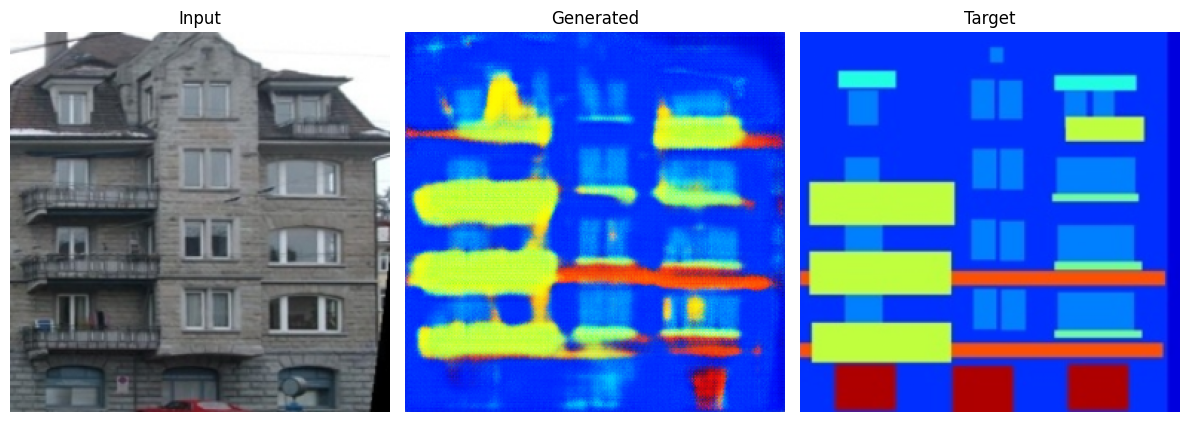

Saved result_1.png


<Figure size 640x480 with 0 Axes>

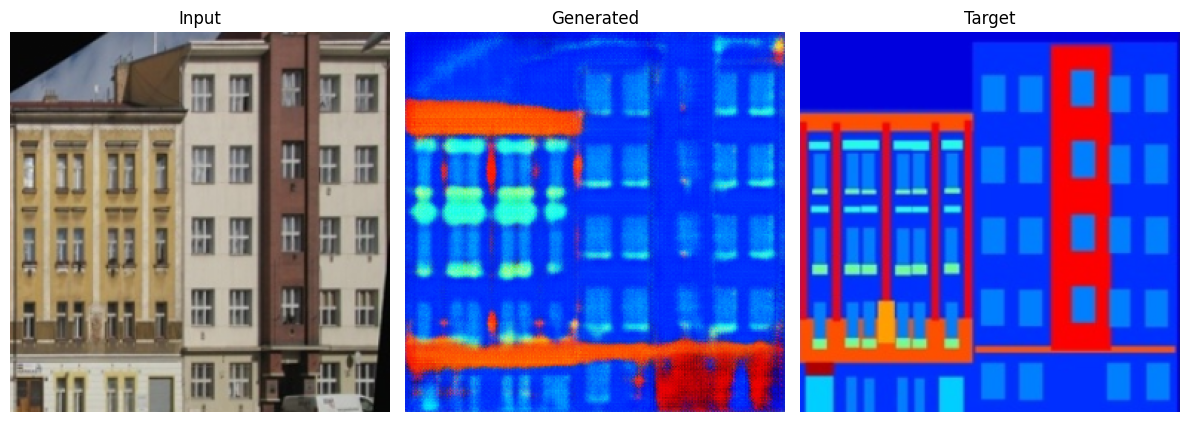

Saved result_2.png


<Figure size 640x480 with 0 Axes>

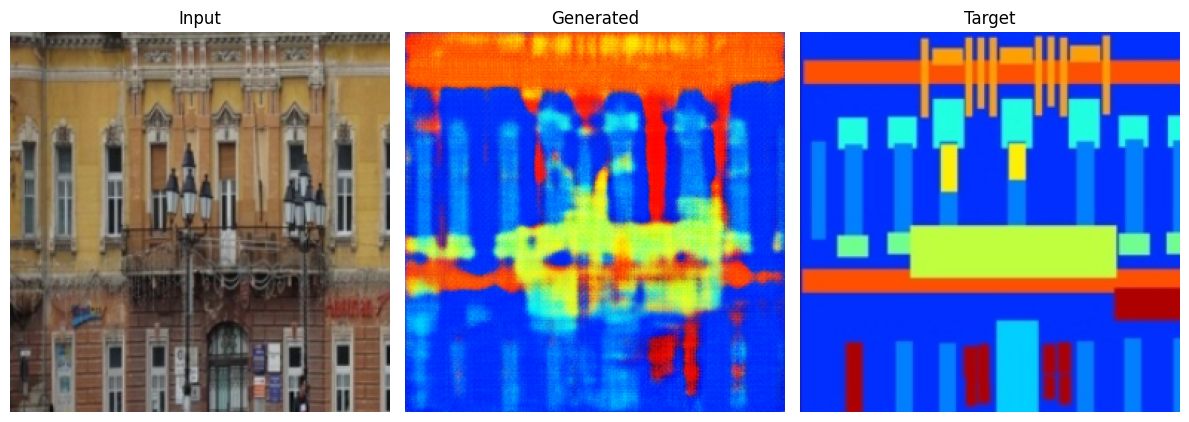

Saved result_3.png


<Figure size 640x480 with 0 Axes>

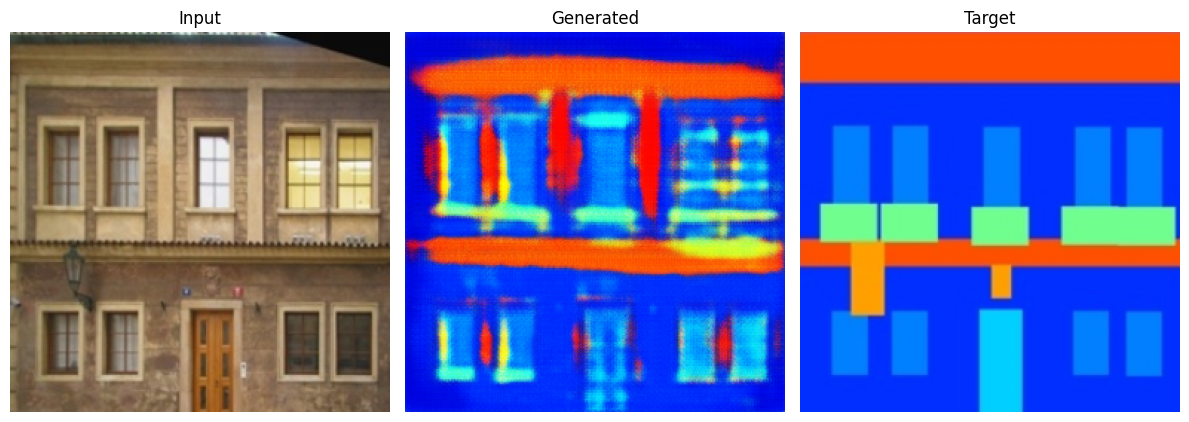

Saved result_4.png


<Figure size 640x480 with 0 Axes>

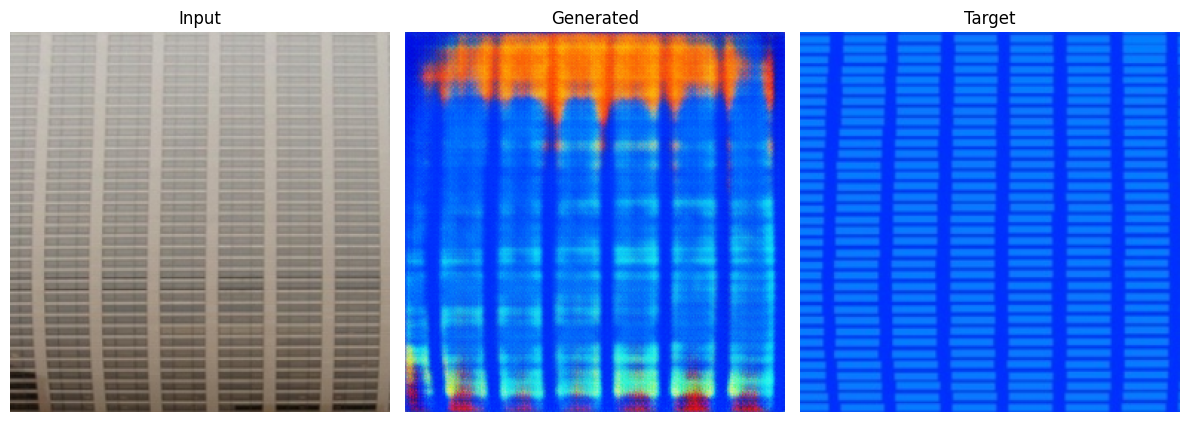

Saved result_5.png
Testing complete.


<Figure size 640x480 with 0 Axes>

In [14]:
test_dataset = Pix2PixDataset('/content/drive/MyDrive/pix2pix_datasets/facades', mode='val')
test_pix2pix(generator=gen, test_dataset=test_dataset, num_samples=5, save_results=False)

## Evaluate model


In [16]:
!pip install pytorch-ssim piq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 5.4 MB/s eta 0:00:00
  Created wheel for pytorch-ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2006 sha256=c1d78a0a79b53fe9cca1e9118f3e072d60ad8a4feafed40adb83f54af6159f17
  Stored in directory: /root/.cache/pip/wheels/54/a0/11/99f86224e71729ed9ef0c4ffe1b795807ad5f44bde19bc66f9
Successfully built pytorch-ssim


In [26]:
import piq  # perceptual image quality metrics

def evaluate_pix2pix_metrics(generator, test_dataset, device=None, num_samples=None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = generator.to(device)
    generator.eval()

    psnr_vals, ssim_vals = [], []
    real_imgs, fake_imgs = [], []

    loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # one at a time
        shuffle=False,
        num_workers=2
    )

    num_samples = num_samples or len(loader)

    with torch.no_grad():
        for i, (input_img, target_img) in enumerate(tqdm(loader, total=num_samples)):
            if i >= num_samples:
                break

            input_img, target_img = input_img.to(device), target_img.to(device)
            gen_img = generator(input_img)

            # Denormalize [-1, 1] → [0, 1]
            def denorm(x):
                return (x + 1) / 2

            gen_img = torch.clamp(denorm(gen_img), 0, 1)
            target_img = torch.clamp(denorm(target_img), 0, 1)

            # Remove batch dim for PSNR/SSIM (expect [C, H, W])
            g = gen_img.squeeze(0)
            t = target_img.squeeze(0)

            # PSNR & SSIM
            psnr_vals.append(piq.psnr(g.unsqueeze(0), t.unsqueeze(0), data_range=1.).item())
            ssim_vals.append(piq.ssim(g.unsqueeze(0), t.unsqueeze(0), data_range=1.).item())

            # Collect for FID (needs [N, C, H, W])
            real_imgs.append(t.cpu())
            fake_imgs.append(g.cpu())

    # Ensure tensors are stacked correctly
    real_imgs = torch.stack(real_imgs)  # shape: [N, C, H, W]
    fake_imgs = torch.stack(fake_imgs)

    # Compute FID
    fid_metric = piq.FID()
    fid_val = fid_metric(fake_imgs, real_imgs).item()

    # Mean values
    psnr_mean = np.mean(psnr_vals)
    ssim_mean = np.mean(ssim_vals)

    print(f"Evaluation Metrics:")
    print(f"PSNR: {psnr_mean:.4f}")
    print(f"SSIM: {ssim_mean:.4f}")
    print(f"FID:  {fid_val:.4f}")

    return {"PSNR": psnr_mean, "SSIM": ssim_mean, "FID": fid_val}


In [27]:
gen = UNetGenerator()
gen.load_state_dict(torch.load('/content/drive/MyDrive/pix2pix_checkpoints/pix2pix_generator_23:02:50.pth', map_location='cuda'))
gen.eval()

test_dataset = Pix2PixDataset('/content/drive/MyDrive/pix2pix_datasets/facades', mode='val')

metrics = evaluate_pix2pix_metrics(generator=gen, test_dataset=test_dataset, num_samples=50)

100%|██████████| 50/50 [00:00<00:00, 50.89it/s]


AssertionError: Expected number of dimensions to be 2, got 4